In [33]:
import numpy as np
import pandas as pd
import os, glob
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

In [7]:
# Read stress vectors
def read_txt(fname):
    with open(fname, 'r+', encoding = "utf-8") as f:
        lines = [l.strip().split('\t') for l in f.readlines()]
    return lines

# Aggregate to a list with each item being each song
def create_song_list(txt):
    song_list = []
    song = []
    for line in txt:
        if line[0][:7] == '!!!EST:':
            song_list.append(song)
            song = []
        else:
            song.append(line)
    return song_list

def read_all_txt(files):
    song_list = []
    for f in files:
        txt = read_txt(f)
        song_list += create_song_list(txt)
    return song_list

# Convert song to measures
def create_measure_list(song):
    measure_list = []
    measure = []
    for line in song:
        if line[0][0][0] == '=':
            measure_list.append(measure)
            measure = []
        else:
            measure.append(line)
    return measure_list

# Convert song to phrases
def create_phrase_list(song, minLength):
    phrase_list = []
    phrase = []
    for i, line in enumerate(song):
        try:
            # if i == 0:
            #     phrase.append(line)
            if line[2] in ['4', '5']:
                if len(phrase) >= minLength:
                    phrase_list.append(phrase)
                phrase = []
                phrase.append(line)
            elif line[2][0] == '=':
                continue
            else:
                phrase.append(line)
        except:
            continue
    return phrase_list

def create_custom_list(song, basisVectorSize):
    """
    Create a custom grouping of vectors based on the basis vector size
    Input: song array, basis vector size
    Output: A list with sublists of length = basisVectorSize as each item. One sublist ends when sum(1/line[0]) = 1 and basisVectorSize is reached for line in song
    """
    
    basis = basisVectorSize
    dict = {'16%13' : 13*basis/16, '24' : basis/24, '32%5': 5*basis/32, '12': basis/12, '8%5': 5*basis/8, '.': basis/4, '16%9': 9*basis/16, 
    '16%11': 11*basis/16, '16%15': 15*basis/16, '32%31': 31*basis/32, '16%5': 5*basis/16, '32%9': 9*basis/32, '6': basis/6, '3': basis/3, 
    '1': basis, '2': basis/2, '4': basis/4, '8': basis/8, '16': basis/16, '32': basis/32, '8.': 1.5*basis/8, '2..': 1.75*basis/2, 
    '4.': 1.5*basis/4, '16.': 1.5*basis/16, '2.': 1.5*basis/2, '4..': 1.75*basis/4, '2...': 1.875*basis/2, '.': 0}

    vectorLength = 0
    custom_list = []
    custom = []
    init = False
    for line in song:
        # Only start appending when first element appears which is in dict and not a .
        if init is False:
            if line[0][0] in dict and line[0][0] != '.':
                init = True
                custom.append(line)
                vectorLength += dict[line[0][0]]


        else:
            if line[0][0] in dict:
                if vectorLength < basisVectorSize:
                    custom.append(line)
                    # print (custom)
                    vectorLength += 1
                elif vectorLength == basisVectorSize:
                    custom_list.append(custom)
                    custom = []
                    vectorLength = 0
            
    return custom_list

def create_measure_list_all(song_list):
    measure_list_all = []
    for song in song_list:
        measure_list = create_measure_list(song)
        measure_list_all.append(measure_list)
    return measure_list_all

def create_phrase_list_all(song_list, minLength):
    phrase_list_all = []
    for song in song_list:
        phrase_list = create_phrase_list(song, minLength)
        phrase_list_all.append(phrase_list)
    return phrase_list_all

def create_custom_list_all(song_list, basisVectorSize):
    custom_list_all = []
    for song in song_list:
        custom_list = create_custom_list(song, basisVectorSize)
        custom_list_all.append(custom_list)
    return custom_list_all

def get_phrase_lengths(song):
    return [len(p) for p in song]

def getTotalPhrases(song_list):
    """
    input: dataset array consisting of all songs by phrases
    output: Total number of phrases in the array
    """
    return sum([len(song) for song in song_list])

In [8]:
def pad(song, durations):
    padding = ['.', '.', '.', '.', '.']
    
    # Append the padding vector n times to after line of a song. n = durations[i] for line i
    padded = []
    for i, line in enumerate(song):
        padded.append(line)
        for j in range(int(durations[i])-1):
            padded.append(padding)
    
    return padded

def slice(padded, basisVectorSize):
    length = len(padded)
    numSlices = int(np.ceil(length/basisVectorSize))
    slices = [None]*numSlices
    for i in range(numSlices):
        slices[i] = padded[i*basisVectorSize:(i+1)*basisVectorSize]
        # print (f'len slices[i]: {len(slices[i])}')
    return slices

def create_metpos_list(song, basisVectorSize):
    basis = basisVectorSize
    dict = {'16%13' : 13*basis/16, '24' : basis/24, '32%5': 5*basis/32, '12': basis/12, '8%5': 5*basis/8, '.': basis/4, '16%9': 9*basis/16, 
    '16%11': 11*basis/16, '16%15': 15*basis/16, '32%31': 31*basis/32, '16%5': 5*basis/16, '32%9': 9*basis/32, '6': basis/6, '3': basis/3, 
    '1': basis, '2': basis/2, '4': basis/4, '8': basis/8, '16': basis/16, '32': basis/32, '8.': 1.5*basis/8, '2..': 1.75*basis/2, 
    '4.': 1.5*basis/4, '16.': 1.5*basis/16, '2.': 1.5*basis/2, '4..': 1.75*basis/4, '2...': 1.875*basis/2, '.': 0}
    
    pad_lengths = []
    song_clean = []
    
    for line in song:
        vectorLength = 0
        recip = line[0]
        if recip in dict:
            pad_length = dict[recip]
            pad_lengths.append(pad_length)
            song_clean.append(line)

    # print (f'len song_clean: {len(song_clean)}') #, song_clean: {song_clean}')
    song_clean = pad(song_clean, pad_lengths)
    # print (f'len padded: {len(song_clean)}') #, song_clean: {song_clean}')
    # print (len(song_clean[0]))
    # print (song_clean[0])
    song_clean = slice(song_clean, basisVectorSize)
    # print (f'len sliced: {len(song_clean)}, len sliced[0]: {len(song_clean[0])}')
    # print (len(song_clean[0]))
    
    return song_clean

def create_metpos_list_all(song_list, basisVectorSize):
    metpos_list_all = []
    for song in song_list:
        metpos_list = create_metpos_list(song, basisVectorSize)
        metpos_list_all.extend([metpos_list])
        # print (f'len(metpos_list_: {len(metpos_list)}, len(metpos_list_all): {len(metpos_list_all)}')
    return metpos_list_all

In [9]:
def extract_features(phrase):
    """
    Input: a phrase
    Output: a list of features
    """
    durations = []
    stresses = []
    lyrics = []
    for line in phrase:
        try:
            durations.append(line[0])
            # print (f'stress: {line[1]}, type: {type(line[1])}')
            stresses.append(line[1])
            lyrics.append(line[3])
            # print (f'dur: {line[0]}, stress: {line[1]}, lyric: {line[3]}, metpos: {line[4]}')
        except:
            continue
    return durations, stresses, lyrics

def extract_features_from_song(phrases):
    """
    Input: a song
    Output: a list of features
    """
    durations_phrases = []
    stresses_phrases = []
    lyrics_phrases = []
    for phrase in phrases:
        durations, stresses, lyrics = extract_features(phrase)
        if durations != []:
            durations_phrases.append(durations)
            stresses_phrases.append(stresses)
            lyrics_phrases.append(lyrics)
    return durations_phrases, stresses_phrases, lyrics_phrases

def extract_features_from_song_list(song_list):
    """
    Input: a list of songs
    Output: a list of features
    """
    durations_all = []
    stresses_all = []
    lyrics_all = []
    for song in tqdm(song_list):
        durations, stresses, lyrics = extract_features_from_song(song)
        durations_all.append(durations)
        stresses_all.append(stresses)
        lyrics_all.append(lyrics)
    return durations_all, stresses_all, lyrics_all

In [34]:
# Read dataset
vector_size = 96
dirPath = f'extracted/metpos/{vector_size}'
files = glob.glob(os.path.join(dirPath, '*.txt'))
print (len(files))

21


In [35]:
songs = read_all_txt(files)
print (f'dataset size: {len(songs)}')

dataset size: 121


In [40]:
song_measures = create_measure_list_all(songs)
song_phrases = create_phrase_list_all(songs, minLength = 4)
song_custom = create_custom_list_all(songs, vector_size)
song_metpos  = create_metpos_list_all(songs, vector_size)
print (f'song phrases: {len(song_phrases)}. song measures: {len(song_measures)}. custom: {len(song_custom)}, metpos: {len(song_metpos)}')

song phrases: 121. song measures: 121. custom: 121, metpos: 121


In [41]:
print (len(song_metpos[0][0]))

96


In [42]:
print (f'len custom: {len(song_custom[0][3])}, len custom[0]: {type(song_custom[0][0])}, custom: {len(song_custom[0][0][0])}')
print (f'len measure: {len(song_measures[0][1])}, len measures[0]: {type(song_measures[0][1])}, measure: {len(song_measures[0][1][0])}')
print (f'len metpos: {len(song_metpos[0][1])}, len metpos[0]: {type(song_metpos[0][1])}, metpos: {len(song_metpos[0][0][0])}')

len custom: 96, len custom[0]: <class 'list'>, custom: 5
len measure: 7, len measures[0]: <class 'list'>, measure: 5
len metpos: 96, len metpos[0]: <class 'list'>, metpos: 5


In [43]:
# print (song_metpos[0][0])

In [740]:
songNum = 0
index = 1
song = songs[songNum]
measures_test = create_measure_list(song)
phrases_test = create_phrase_list(song, minLength=4)
custom_test = create_custom_list(song, vector_size)
print (f'len measures: {len(measures_test)}, len phrases: {len(phrases_test)}, len custom: {len(custom_test)}')
print (f'len measures[index]: {len(measures_test[index])}, len phrases[index]: {len(phrases_test[index])}, len custom[index]: {len(custom_test[index])}')

len measures: 51, len phrases: 59, len custom: 6
len measures[index]: 7, len phrases[index]: 12, len custom[index]: 96


In [741]:
# print (custom_test[1])
# print (measures_test[1])
# print (phrases_test[1])

In [45]:
# Get dataset phrase summary
total_phrases = getTotalPhrases(song_phrases)
total_measures = getTotalPhrases(song_measures)
total_custom = getTotalPhrases(song_custom)
total_metpos = getTotalPhrases(song_metpos)
phrases_per_song = total_phrases/len(songs)
measures_per_song = total_measures/len(songs)
custom_per_song = total_custom/len(songs)
metpos_per_song = total_metpos/len(songs)
print (f'total_phrases: {total_phrases}. phrases_per_song: {phrases_per_song}')
print (f'total_measures: {total_measures}. measures_per_song: {measures_per_song}')
print (f'total_custom: {total_custom}. custom_per_song: {custom_per_song}')
print (f'total_metpos: {total_metpos}. metpos_per_song: {metpos_per_song}')

total_phrases: 7273. phrases_per_song: 60.107438016528924
total_measures: 6262. measures_per_song: 51.752066115702476
total_custom: 729. custom_per_song: 6.024793388429752
total_metpos: 6269. metpos_per_song: 51.8099173553719


In [743]:
# features = extract_features_from_song(song_phrases)

In [744]:
# phraseNum = 1
# [print (len(features[phraseNum][i])) for i in range(4)]
# print (f'len features: {len(features)}; len features[0]: {len(features[0])}; len features[0][0]: {len(features[0][42])}')

In [46]:
# durations_phrases, stresses_phrases, lyrics_phrases, metpositions_phrases = extract_features_from_song(song_phrases[0])
recips_phrases_dataset, stresses_phrases_dataset, lyrics_phrases_dataset = extract_features_from_song_list(song_phrases)
recips_measures_dataset, stresses_measures_dataset, lyrics_measures_dataset = extract_features_from_song_list(song_measures)
recips_custom_dataset, stresses_custom_dataset, lyrics_custom_dataset = extract_features_from_song_list(song_custom)
recips_metpos_dataset, stresses_metpos_dataset, lyrics_metpos_dataset = extract_features_from_song_list(song_metpos)

100%|██████████| 121/121 [00:01<00:00, 115.26it/s]


In [47]:
print (song_custom[0][0][0])
print (song_metpos[0][0][0])

['2', '.', '.', '.', '2.58496']
['2', '.', '.', '.', '2.58496']


In [48]:
print (f'stresses phrases: {len(stresses_phrases_dataset)}, stresses[0]: {len(stresses_phrases_dataset[0])}, stresses[0][0]: {len(stresses_phrases_dataset[0][0])}')
print (f'stresses measures: {len(stresses_measures_dataset)}, stresses[0]: {len(stresses_measures_dataset[0])}, stresses[0][0]: {len(stresses_measures_dataset[0][0])}')
print (f'stresses custom: {len(stresses_custom_dataset)}, stresses[0]: {len(stresses_custom_dataset[0])}, stresses[0][0]: {len(stresses_custom_dataset[0][0])}')
print (f'stresses metpos: {len(stresses_metpos_dataset)}, stresses[0]: {len(stresses_metpos_dataset[0])}, stresses[0][0]: {len(stresses_metpos_dataset[0][0])}')

stresses phrases: 121, stresses[0]: 59, stresses[0][0]: 14
stresses measures: 121, stresses[0]: 50, stresses[0][0]: 7
stresses custom: 121, stresses[0]: 6, stresses[0][0]: 49
stresses metpos: 121, stresses[0]: 51, stresses[0][0]: 96


In [49]:
# print (stresses_custom_dataset[0][0])
# print (stresses_metpos_dataset[0][0])
num = 1
print (stresses_metpos_dataset[0][num])
print (stresses_measures_dataset[0][num])
print (recips_measures_dataset[0][num])
# print (lyrics_metpos_dataset[0][num])
# print (recips_metpos_dataset[0][num])

['1', '.', '.', '.', '.', '.', '0', '.', '.', '.', '.', '.', '1', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '1', '.', '.', '.', '.', '.', '0', '.', '.', '.', '.', '.', '1', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '1', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '1', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '1', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '1', '.', '.', '.', '.', '.', '0', '.', '.', '.', '.', '.']
['1', '0', '1', '1', '0', '1', '1', '1', '1', '1', '0']
['16', '16', '8', '16', '16', '8', '8', '8', '8', '16', '16']


In [50]:
def get_recips_dur_phrase(recips, basis):
    """
    Input an array containing recips of a phrase
    Returns duration of a phrase in note durations
    """
    dict = {'16%13' : 13*basis/16, '24' : basis/24, '32%5': 5*basis/32, '12': basis/12, '8%5': 5*basis/8, '.': basis/4, '16%9': 9*basis/16, 
    '16%11': 11*basis/16, '16%15': 15*basis/16, '32%31': 31*basis/32, '16%5': 5*basis/16, '32%9': 9*basis/32, '6': basis/6, '3': basis/3, 
    '1': basis, '2': basis/2, '4': basis/4, '8': basis/8, '16': basis/16, '32': basis/32, '8.': 1.5*basis/8, '2..': 1.75*basis/2, 
    '4.': 1.5*basis/4, '16.': 1.5*basis/16, '2.': 1.5*basis/2, '4..': 1.75*basis/4, '2...': 1.875*basis/2, '.': 0}
    notePhrase = 0
    for recip in recips:
        if recip in dict:
            if recip != '.':
                dur = 1./int(dict[recip])
            else:
                dur = 0
            notePhrase += dur
    
    return notePhrase

### Get unique stress patterns in a song

In [51]:
def get_unique_values(stressVectorsSong):
    return [list(x) for x in set(tuple(x) for x in stressVectorsSong)]

def get_repeat_proportion_duration(stresses_dataset):
    proportion = np.array([])
    for songNum in np.arange(len(stresses_dataset)):
        stressVectorsSong = stresses_dataset[songNum]
        unique_data = get_unique_values(stressVectorsSong)
        # print (f'unique vectors: {len(unique_data)}. stressVectorsSong: {len(stressVectorsSong)}')
        proportion = np.append(proportion, len(stressVectorsSong)/len(unique_data))
    return proportion

def get_stress_vector_lengths(stresses_dataset):
    lengths = []
    for songNum, song in enumerate(stresses_dataset):
        lengths_song = []
        for chunk in song:
            lengths_song.append(len(chunk))
        lengths.append(lengths_song)
    return lengths

In [52]:
prop = get_repeat_proportion_duration(stresses_measures_dataset)
print (f'Measures: max: {np.max(prop)}, min: {np.min(prop)}, mean: {np.mean(prop)}, median: {np.median(prop)}')

prop = get_repeat_proportion_duration(stresses_phrases_dataset)
print (f'Phrases: max: {np.max(prop)}, min: {np.min(prop)}, mean: {np.mean(prop)}, median: {np.median(prop)}')

prop = get_repeat_proportion_duration(stresses_custom_dataset)
print (f'Custom: max: {np.max(prop)}, min: {np.min(prop)}, mean: {np.mean(prop)}, median: {np.median(prop)}')

Measures: max: 2.2941176470588234, min: 1.0, mean: 1.121238861185974, median: 1.044776119402985
Phrases: max: 3.7142857142857144, min: 1.0, mean: 1.2481753115710474, median: 1.1458333333333333
Custom: max: 1.0, min: 1.0, mean: 1.0, median: 1.0


In [23]:
# plt.plot(stresses_metpos_dataset[0][2])
# Plot for a song

def extract_stress_plot_data(stresses_metpos):
    vector_size = len(stresses_metpos)
    zeros = np.zeros(vector_size)
    ones = np.zeros(vector_size)
    rests = np.zeros(vector_size)
    for i, s in enumerate(stresses_metpos):
        for k in range(len(s)):
            if s[k] == '0':
                zeros[k] += 1
            if s[k] == '1':
                ones[k] += 1
            if s[k] == '.':
                rests[k] += 1
    
    return zeros, ones, rests

songNum = 1
zeros, ones, rests = extract_stress_plot_data(stresses_metpos_dataset[songNum])
print (ones)

IndexError: index 51 is out of bounds for axis 0 with size 51

In [24]:
# stresses_metpos_dataset[0]

NameError: name 'zeros' is not defined

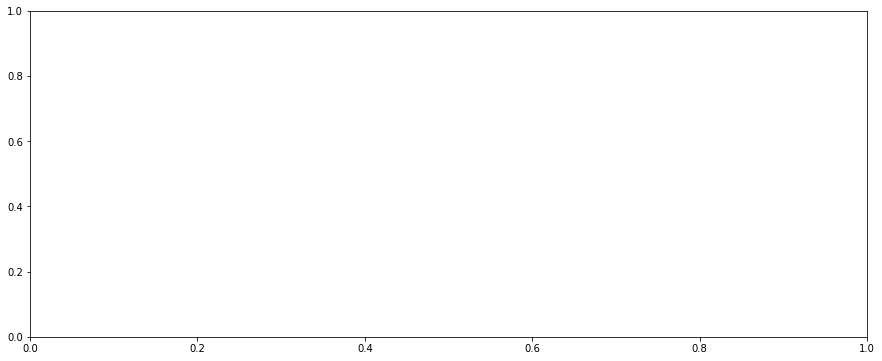

In [25]:
# plt.figure(figsize = (15, 9))
# plt.stackplot(np.arange(vector_size), zeros, ones, labels=['0', '1'])
# plt.title('')
# plt.ylabel('Number of phrases')

labels = np.arange(vector_size)

fig, ax = plt.subplots(figsize = (15, 6))

ax.bar(labels, zeros, label='Zero')
# ax.bar(labels, ones, bottom=zeros,
#        label='Ones')
ax.set_ylabel('Number of phrases')
ax.set_title('Stressed vs unstressed utterances for a song')
ax.legend()

plt.show()

NameError: name 'zeros' is not defined

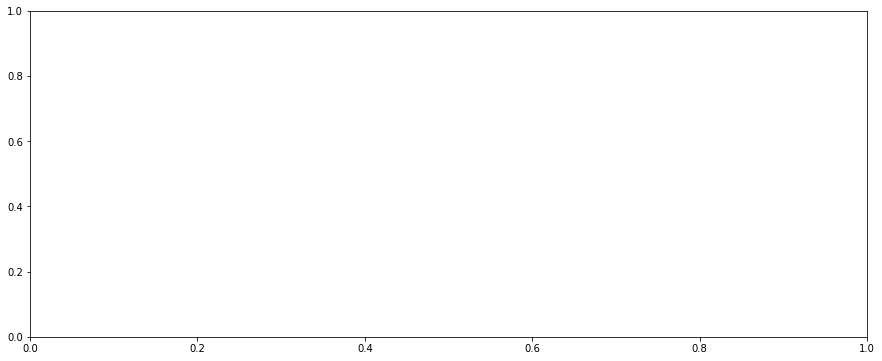

In [26]:
labels = np.arange(vector_size)
fig, ax = plt.subplots(figsize = (15, 6))
ax.bar(labels, zeros, label='Zero')
ax.set_xlabel('Metric position')
ax.set_ylabel('Number of phrases')
ax.set_title('Unstressed utterances aggregated for a song by metric position')
# plt.savefig('images/unstressed.png')

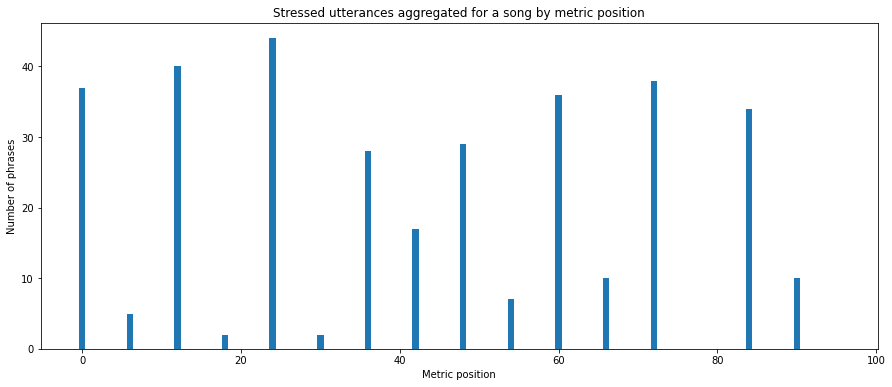

In [864]:
labels = np.arange(vector_size)
fig, ax = plt.subplots(figsize = (15, 6))
ax.bar(labels, ones, label='One')
ax.set_xlabel('Metric position')
ax.set_ylabel('Number of phrases')
ax.set_title('Stressed utterances aggregated for a song by metric position')
# plt.savefig('images/stressed.png')

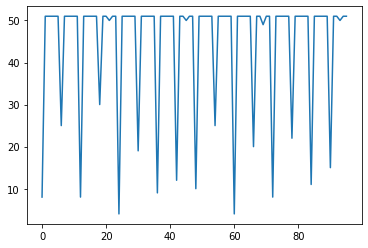

In [755]:
plt.plot(rests)

(array([80., 13., 10.,  4.,  5.,  1.,  2.,  0.,  1.,  2.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([1.        , 1.07222222, 1.14444444, 1.21666667, 1.28888889,
        1.36111111, 1.43333333, 1.50555556, 1.57777778, 1.65      ,
        1.72222222, 1.79444444, 1.86666667, 1.93888889, 2.01111111,
        2.08333333, 2.15555556, 2.22777778, 2.3       , 2.37222222,
        2.44444444]),
 <BarContainer object of 20 artists>)

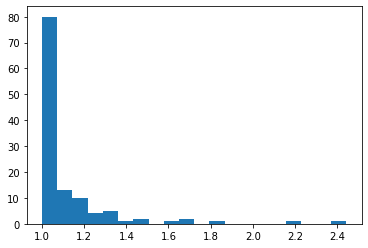

In [756]:
plt.hist(prop, bins = 20)

### Find distribution of vector lengths in each song

In [757]:
# vectorSizeMetric = number of unique lengths/total number of lengths for each song

In [27]:
measuresVectorLengths = get_stress_vector_lengths(stresses_measures_dataset)
phrasesVectorLengths = get_stress_vector_lengths(stresses_phrases_dataset)
customVectorLengths = get_stress_vector_lengths(stresses_custom_dataset)

In [28]:
print (f'measures: {len(measuresVectorLengths)}, phrases: {len(phrasesVectorLengths)}')
print (f'len measures[0]: {len(measuresVectorLengths[0])}, phrases[0]: {len(phrasesVectorLengths[0])}')
print (f'measures[0][0]: {measuresVectorLengths[0][1]}, phrases[0][0]: {phrasesVectorLengths[0][0]}')

measures: 121, phrases: 121
len measures[0]: 50, phrases[0]: 59
measures[0][0]: 11, phrases[0][0]: 14


In [53]:
# Find number of patterns overflowing a whole note duration. Get prop per song as well
def get_overflowing_patterns(dataset_matrix, basis):
    """
    Returns pattern length in terms of note durations and featureVectorSize for every song
    Input: dataset_matrix = any feature matrix of the form [song][measure/phrase][feature]. eg - recips_measures_dataset, stresses_phrases_dataset, etc.
    """
    segment_lengths_dur = []
    segment_lengths = []
    for songNum, song in enumerate(dataset_matrix):
        lengths_dur = []
        lengths = []
        for recip in song:
            length = get_recips_dur_phrase(recip, basis)
            lengths.append(len(recip))
            lengths_dur.append(length)
        segment_lengths_dur.append(lengths_dur)
        segment_lengths.append(lengths)
    return segment_lengths_dur, segment_lengths

In [54]:
sld_phrases, sl_phrases = get_overflowing_patterns(recips_phrases_dataset, vector_size)
sld_measures, sl_measures = get_overflowing_patterns(recips_measures_dataset, vector_size)
sld_custom, sl_custom = get_overflowing_patterns(recips_custom_dataset, vector_size)
# sld_metpos, sl_metpos = get_overflowing_patterns(recips_metpos_dataset, vector_size)

In [55]:
len(recips_metpos_dataset[0][0])

96

Text(0, 0.5, 'Phrase length in note durations')

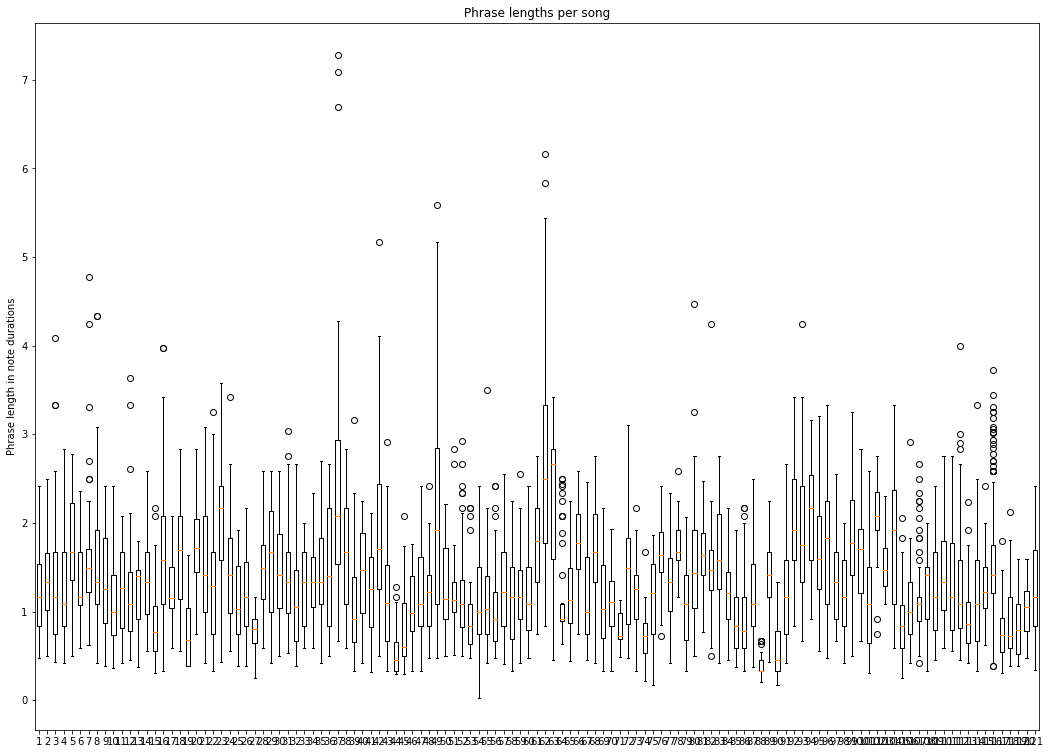

In [56]:
plt.figure(figsize = (18, 13))
plt.boxplot(sld_phrases)
plt.title('Phrase lengths per song')
plt.ylabel('Phrase length in note durations')

Text(0, 0.5, 'Measure length in note durations')

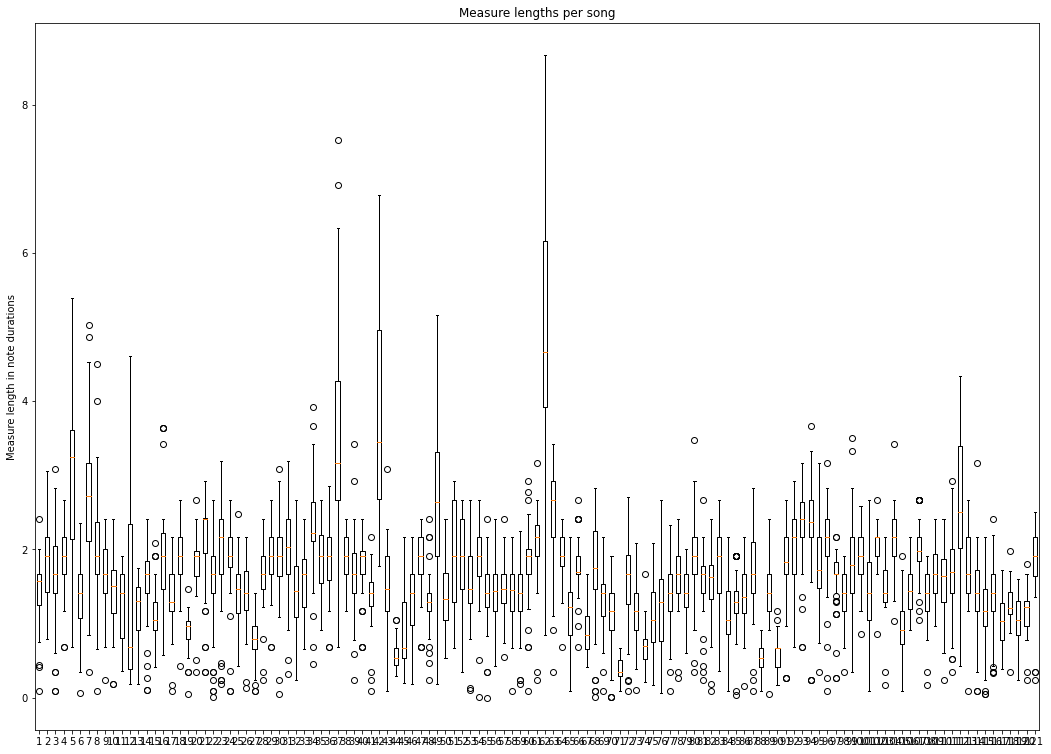

In [775]:
plt.figure(figsize = (18, 13))
plt.boxplot(sld_measures)
plt.title('Measure lengths per song')
plt.ylabel('Measure length in note durations')

Text(0, 0.5, 'Custom length in note durations')

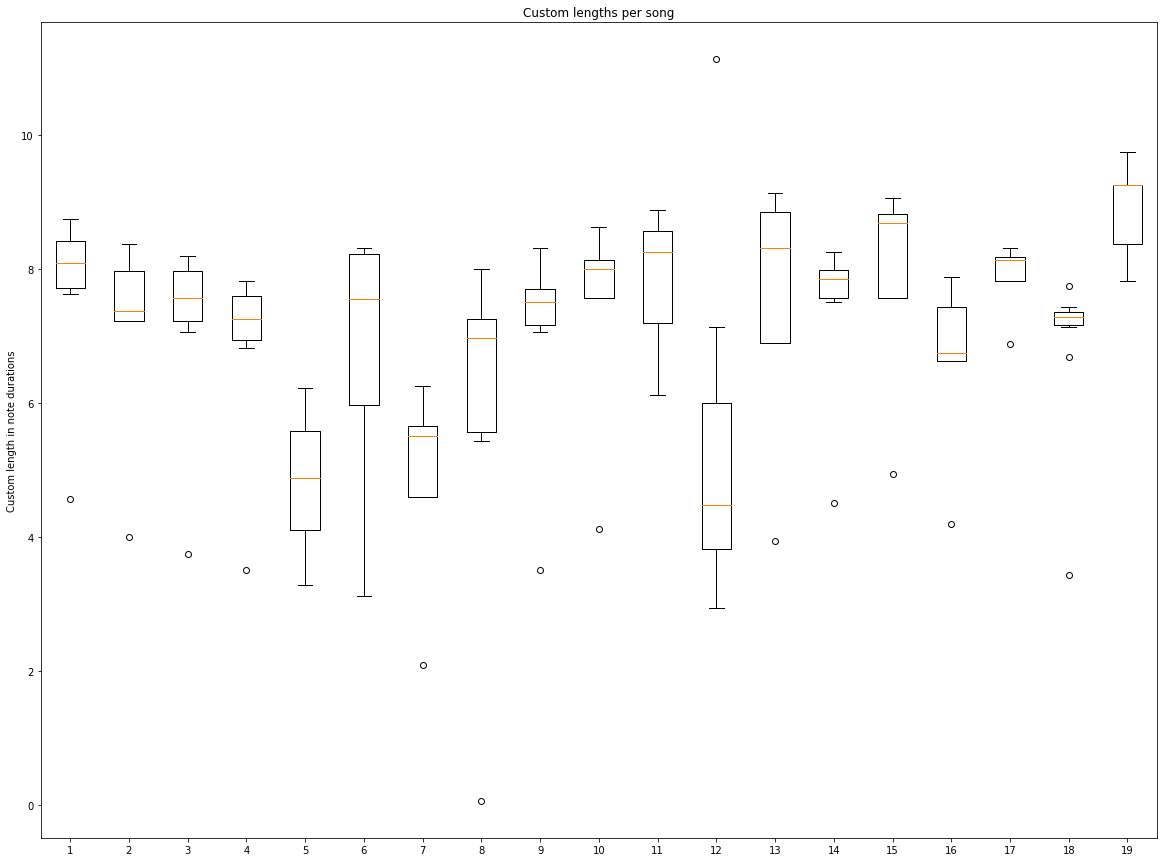

In [432]:
plt.figure(figsize = (20, 15))
plt.boxplot(sld_custom)
plt.title('Custom lengths per song')
plt.ylabel('Custom length in note durations')

Text(0, 0.5, 'Metpos length in note durations')

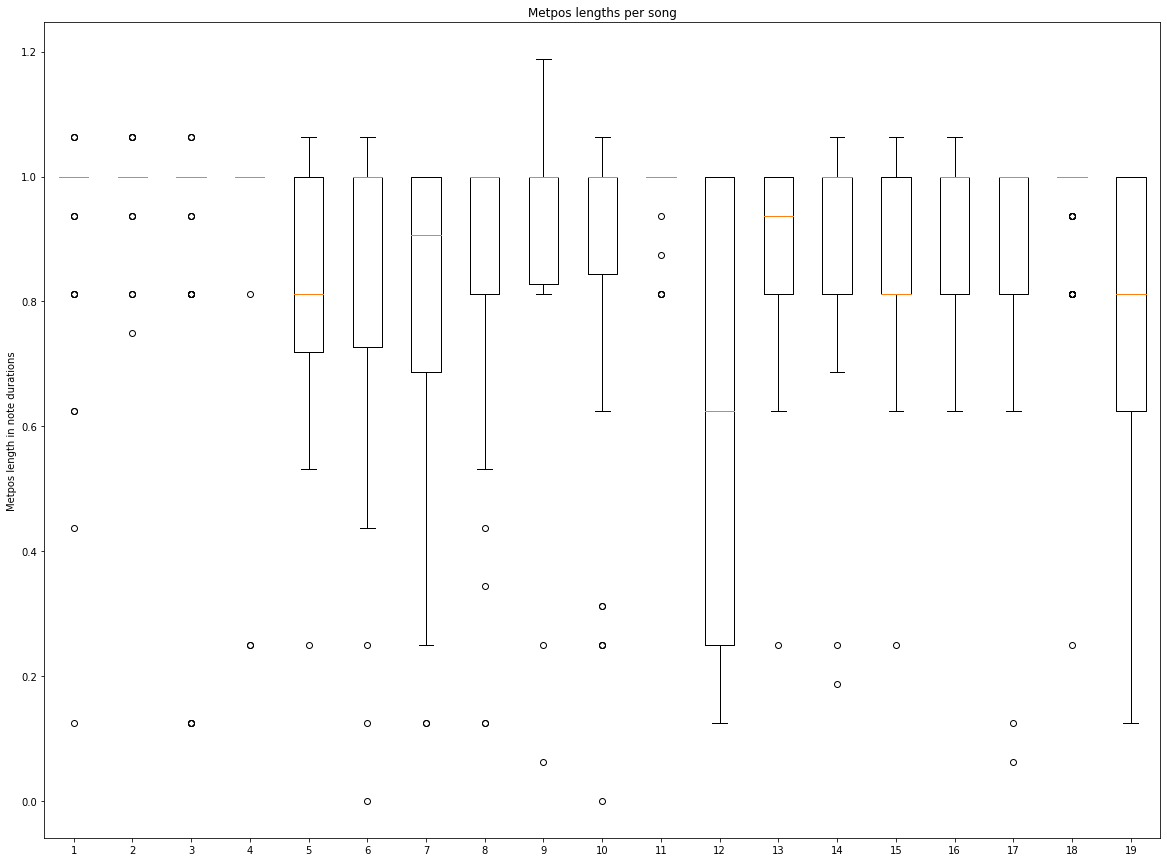

In [433]:
plt.figure(figsize = (20, 15))
plt.boxplot(sld_metpos)
plt.title('Metpos lengths per song')
plt.ylabel('Metpos length in note durations')

In [436]:
sld_metpos

[[1.0,
  1.0,
  1.0,
  1.0625,
  0.9375,
  0.8125,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0625,
  0.9375,
  1.0,
  1.0,
  1.0,
  1.0625,
  0.9375,
  0.125,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.625,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.4375,
  0.8125,
  1.0,
  1.0,
  0.8125,
  0.8125,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.625,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8125,
  0.8125,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0625,
  0.9375,
  1.0,
  1.0625,
  0.75,
  0.8125,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0625,
  0.9375,
  1.0625,
  0.9375],
 [0.125,
  1.0,
  1.0,
  1.0,
  1.0625,
  0.9375,
  0.8125,
  1.0,
  1.0625,
  0.9375,
  1.0,
  1.0,
  0.9999999999999999,
  0.9999999999999999,
  1.0,
  1.0625,
  0.9375,
  0.125,
  1.0,
  0.8125,
  0.8125,
  0.81

In [19]:
# See how small and big measures look like, how many of them are there per song
def measure_length_metric(segment_lengths_dur):
    """
    Returns proportion of measures not overflowing a whole note duration
    Input: segment_lengths_dur vector of measure lengths in terms of note durations
    Returns: a matrix containing proportion of measures not overflowing a whole note duration for each song
    """
    proportion = np.array([])
    for songNum, song in enumerate(segment_lengths_dur):
        proportion = np.append(proportion, np.sum(np.array(song) == 1.)/len(song))
    return proportion
    

Text(0, 0.5, 'Proportion of measures not overflowing a whole note duration')

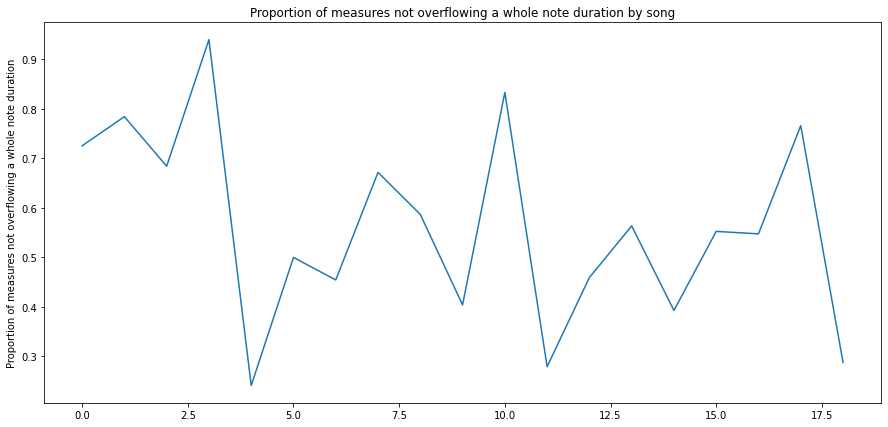

In [435]:
length_metric_measures = measure_length_metric(sld_measures)
length_metric_phrases = measure_length_metric(sld_phrases)
length_metric_custom = measure_length_metric(sld_custom)
length_metric_metpos = measure_length_metric(sld_metpos)

plt.figure(figsize = (15, 7))
plt.plot(length_metric_metpos)
plt.title('Proportion of measures not overflowing a whole note duration by song')
plt.ylabel('Proportion of measures not overflowing a whole note duration')

In [311]:
recips_custom_dataset[0][0]

['2', '.', '.', '.']

In [312]:
min_prop = np.min(length_metric_custom)
min_songNum = np.argmin(length_metric_custom)
max_prop = np.max(length_metric_custom)
max_songNum = np.argmax(length_metric_custom)

print (f'min: {min_prop}, min_songNum: {min_songNum}, max: {max_prop}, max_songNum: {max_songNum}')

min: 0.0, min_songNum: 0, max: 1.0, max_songNum: 7


## Perceptual patterns

In [60]:
# Functionality to reduce dimensionality of 96 length vector

def extract_subvector(vector, target_size):
    vectorSize = len(vector)
    conversion = int(vectorSize//target_size)
    subvector = [None] * target_size
    for i in range(target_size):
        subvector[i] = vector[i*conversion]
    return subvector

def extract_subvectors(vectors, target_size):
    subvectors = []
    for vector in vectors:
        # print (vector)
        subvectors.append(extract_subvector(vector, target_size))
    return subvectors

def extract_subvectors_dataset(stresses_dataset, target_size):
    subvectors_dataset = []
    for stresses_song in stresses_dataset:
        subvectors_dataset.append(extract_subvectors(stresses_song, target_size))
    return subvectors_dataset

In [61]:
subvectors_dataset = extract_subvectors_dataset(stresses_metpos_dataset, 16)
# subvectors_dataset

In [62]:
def stress_frame(frame):
    zs = np.zeros(len(frame))
    os = np.zeros(len(frame))
    rs = np.zeros(len(frame))
    for j, k in enumerate(frame):
        if k == '.':
            rs[j] = 1
        if k == '0':
            zs[j] = 1
        if k == '1':
            os[j] = 1
    return list(zs), list(os), list(rs)

def get_stresses(subvectors):
    len_subvectors = len(subvectors)
    zeros = []
    ones = []
    rests = []

    for i, subvector in enumerate(subvectors):
        zero, one, rest = stress_frame(subvector)
        # print (rest)
        zeros.append(zero)
        ones.append(one)
        rests.append(rest)
    return zeros, ones, rests

def get_stresses_all(songs_subvectors):
    zeros_dataset = []
    ones_dataset = []
    rests_dataset = []
    for song_subvectors in songs_subvectors:
        zeros, ones, rests = get_stresses(song_subvectors)
        zeros_dataset.append(zeros)
        ones_dataset.append(ones)
        rests_dataset.append(rests)
    return zeros_dataset, ones_dataset, rests_dataset


In [63]:
unstresses_dataset_trunc, stresses_dataset_trunc, rests_dataset_trunc = get_stresses_all(subvectors_dataset)

def find_repeat_stressed(dataset_matrix_trunc):
    repeatProp = []
    for i, stresses_song_trunc in enumerate(dataset_matrix_trunc):
        # Find unique values in all songs
        unique = get_unique_values(stresses_song_trunc)
        prop = len(stresses_song_trunc)/len(unique)
        repeatProp.append(prop)
    return repeatProp

In [64]:
repeatProp = find_repeat_stressed(stresses_dataset_trunc)

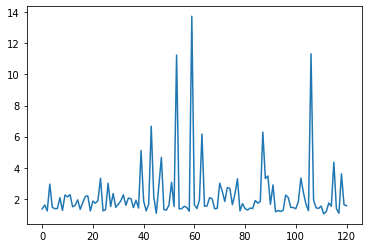

In [65]:
plt.plot(repeatProp)

In [66]:
# Extract year from each song txt file. Year is encoded as BPD in the xml file in column [0]
def extract_year(song):
    for line in song:
        if len(line) == 1 and line[0][:6] == '!!!BPD':
            return line[0][7:11]

def extract_years(songs):
    years = []
    for song in songs:
        year = extract_year(song)
        years.append(year)
    return years

In [67]:
def clean_dataset_by_year(dataset_matrix, years):
    years_avail = [int(years[i]) for i in range(len(years)) if years[i] != "NA"]
    dataset_matrix_clean = [dataset_matrix[i] for i, yr in enumerate(years_avail)]
    return dataset_matrix_clean, years_avail

In [68]:
y = extract_years(songs)
stresses_metpos_dataset_clean, years_clean = clean_dataset_by_year(stresses_metpos_dataset, y)
print (len(stresses_metpos_dataset))
print (len(stresses_metpos_dataset_clean))

121
117


Text(0, 0.5, 'Repetition proportion')

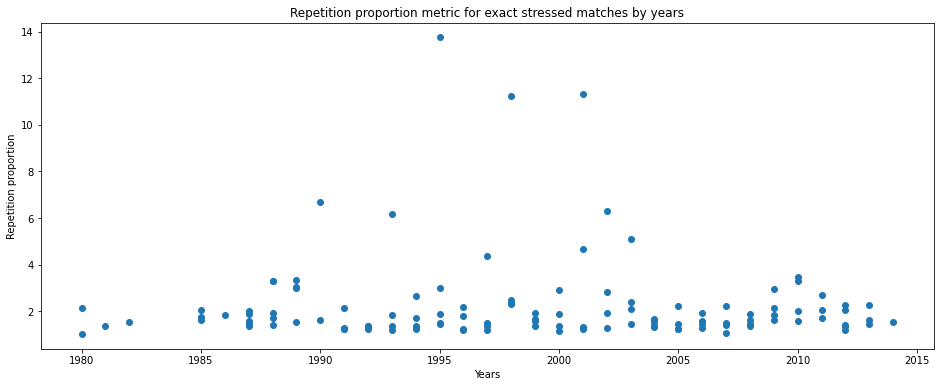

In [69]:
subvectors_dataset_clean = extract_subvectors_dataset(stresses_metpos_dataset_clean, 16)
unstresses_dataset_trunc, stresses_dataset_trunc, rests_dataset_trunc = get_stresses_all(subvectors_dataset_clean)
repeatProp_clean = find_repeat_stressed(stresses_dataset_trunc)
plt.figure(figsize = (16, 6))
plt.scatter(years_clean, repeatProp_clean)
plt.title('Repetition proportion metric for exact stressed matches by years')
plt.xlabel('Years')
plt.ylabel('Repetition proportion')

In [70]:
np.unique(y)

array(['1980', '1981', '1982', '1985', '1986', '1987', '1988', '1989',
       '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', 'NA'], dtype='<U4')

In [71]:
def find_correlation_song(song):
    # Find correlation of each stress vector with all other stress vectors in a song
    # Return a matrix of correlations
    song_corr = np.corrcoef(song)
    return song_corr

In [72]:
corr = find_correlation_song(stresses_dataset_trunc[0])
corr

array([[ 1.        ,  0.16012815,  0.16012815, ..., -0.32387514,
         0.22191676,  0.22191676],
       [ 0.16012815,  1.        ,  1.        , ...,  0.40451992,
         0.62994079,  0.62994079],
       [ 0.16012815,  1.        ,  1.        , ...,  0.40451992,
         0.62994079,  0.62994079],
       ...,
       [-0.32387514,  0.40451992,  0.40451992, ...,  1.        ,
         0.76447079, -0.05096472],
       [ 0.22191676,  0.62994079,  0.62994079, ...,  0.76447079,
         1.        ,  0.23809524],
       [ 0.22191676,  0.62994079,  0.62994079, ..., -0.05096472,
         0.23809524,  1.        ]])

In [85]:
def plot_bar(corr):
    # Read all correlations into a list
    # Plot the list as a bar chart
    corr_list = []
    for i in range(len(corr)):
        for j in range(len(corr)):
            corr_list.append(corr[i][j])
    # Sort corr in ascending order
    corr_list.sort()
    plt.figure(figsize = (16, 6))
    plt.bar(range(len(corr_list)), corr_list)
    plt.title('Correlation of stress vectors in a song')
    plt.xlabel('Stress vector index')
    plt.ylabel('Correlation')
    


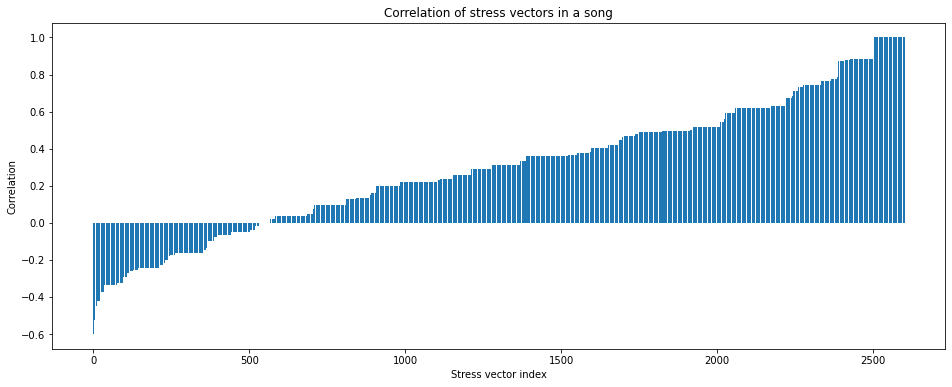

In [86]:
plot_bar(corr)

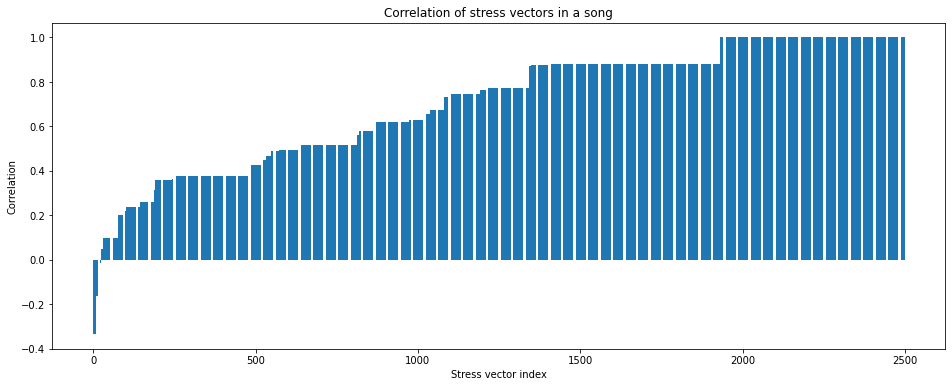

In [89]:
plot_bar(find_correlation_song(stresses_dataset_trunc[3]))

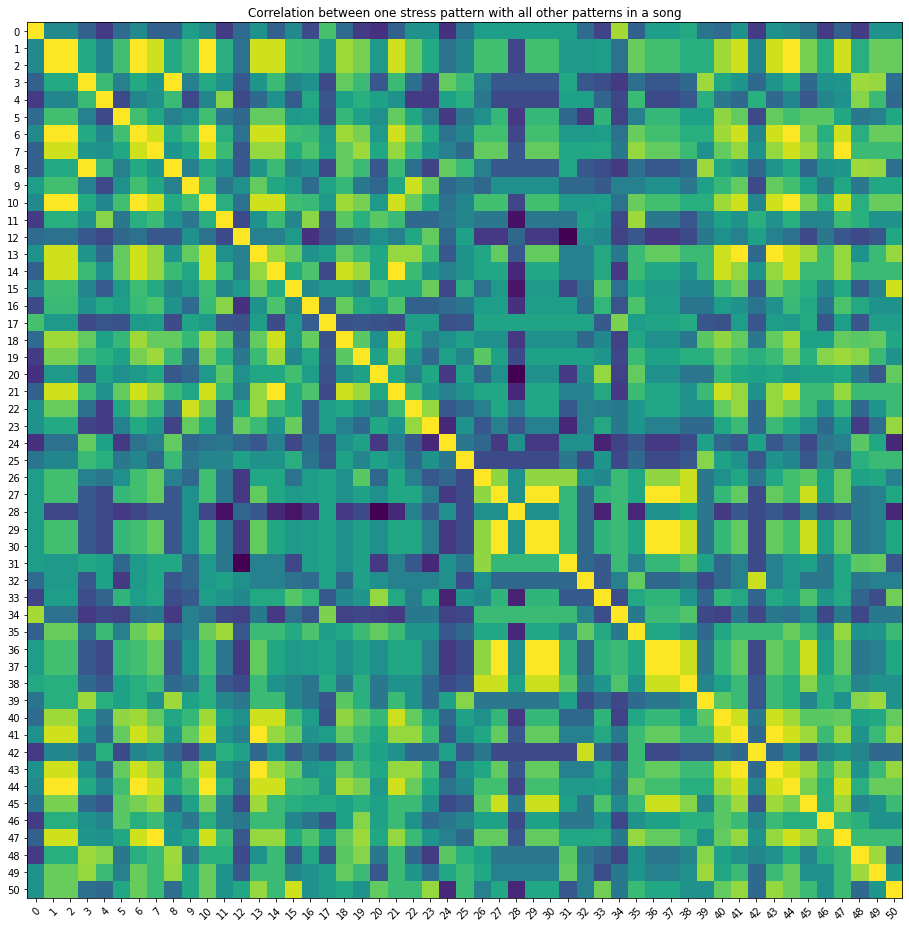

In [73]:
fig, ax = plt.subplots(figsize = (13, 13))
im = ax.imshow(corr)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(corr.shape[0]))
ax.set_yticks(np.arange(corr.shape[1])) # , labels=range(corr.shape[1])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
# for i in range(corr.shape[0]):
#     for j in range(corr.shape[1]):
#         text = ax.text(j, i, corr[i, j],
#                        ha="center", va="center", color="w")

ax.set_title("Correlation between one stress pattern with all other patterns in a song")
fig.tight_layout()
# plt.show()
# plt.savefig('images/correlation.png')

In [74]:
import heapq
def get_similarity(corr, thres):
    nums = np.array([])
    numPatterns = corr.shape[0]
    for crr in corr:
        num = np.where(crr > thres)[0]
        try:
            nums = np.append(nums, len(num)/numPatterns)
        except:
            continue
    return nums

# Write a function to get n largest elements from an array of numbers
def get_n_largest(nums, n):
    array = list(heapq.nlargest(n, nums))
    # array.remove()
    print (array)
    return array

def get_mean_similarity(corr, thres):
    similarity = get_similarity(corr, thres)
    # similarity = get_n_largest(similarity, 6)
    return np.mean(similarity)

def get_mean_similarity_dataset(dataset, thres):
    mean_similarity = []
    for i, song in enumerate(dataset):
        corr = find_correlation_song(song)
        mean_similarity.append(get_mean_similarity(corr, thres))
    return mean_similarity

In [81]:
thres = 0.9
similarity_score_dataset = get_mean_similarity_dataset(stresses_dataset_trunc, thres)

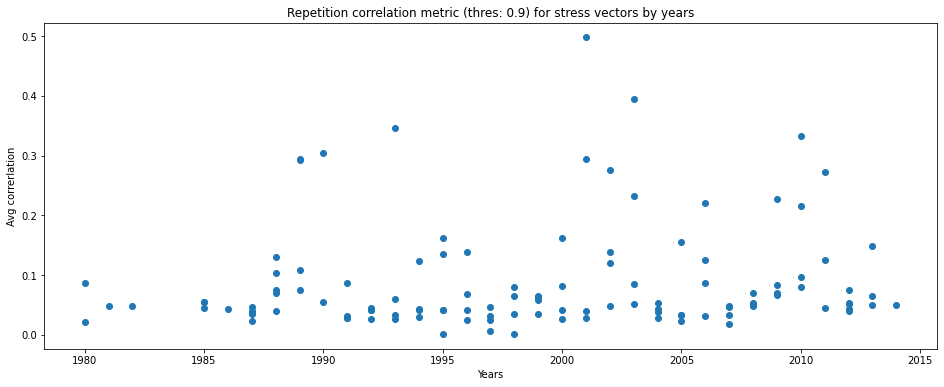

In [80]:
plt.figure(figsize = (16, 6))
plt.scatter(years_clean, similarity_score_dataset)
plt.title(f'Repetition correlation metric (thres: {thres}) for stress vectors by years')
plt.xlabel('Years')
plt.ylabel('Avg correrlation')
plt.savefig(f'images/correlation_metric_{thres}.png')

In [37]:
# Write a function to find the average correlation of all songs in any given year in the dataset
def get_mean_similarity_year(array, years_clean):
    array = np.array(array)
    agg_by_year = []
    years = np.unique(years_clean)
    for year in years:
        index = np.where(np.array(years_clean) == year)[0]
        agg_by_year.append(np.mean(array[index]))
    return agg_by_year, years

In [38]:
aggregated, unique_years = get_mean_similarity_year(similarity_score_dataset, years_clean)

In [39]:
print (len(aggregated))
print (len(unique_years))

33
33


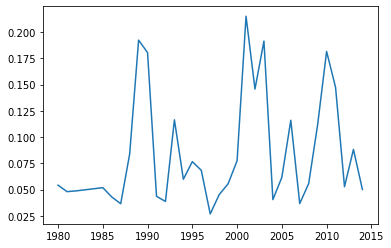

In [40]:
plt.plot(unique_years, aggregated)

## Statistical analysis: H1

In [52]:
# Write a function to load a csv file
import csv
def load_csv(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
    return data

def extract_tempo_years(data):
    tempo = []
    yrs = []
    for i, row in enumerate(data[1:]):
        yr = row[-1]
        if yr != "NA":
            tempo.append(float(row[2]))
            yrs.append(float(row[3]))
    return tempo, yrs

def get_statistical_measures_h1(tempo, yrs):
    mean_by_yr = []
    std_by_yr = []
    unique_yrs = np.sort(np.unique(yrs))
    for yr in unique_yrs:
        index = np.where(np.array(yrs) == yr)[0]
        mean_by_yr.append(np.mean(np.array(tempo)[index]))
        std_by_yr.append(np.std(np.array(tempo)[index]))
    return mean_by_yr, std_by_yr, unique_yrs

In [53]:
data = load_csv('df.csv')
tmps, yrs = extract_tempo_years(data)
mean_by_yr, std_by_yr, unique_yrs = get_statistical_measures_h1(tmps, yrs)

In [ ]:
plt.figure(figsize = (13, 7))
plt.errorbar(unique_yrs, mean_by_yr, std_by_yr, linestyle='None', marker='^')
plt.title('Average and Stdev of BPM over the years')
plt.xlabel('Years')
plt.ylabel('BPM')

Text(0, 0.5, 'BPM')

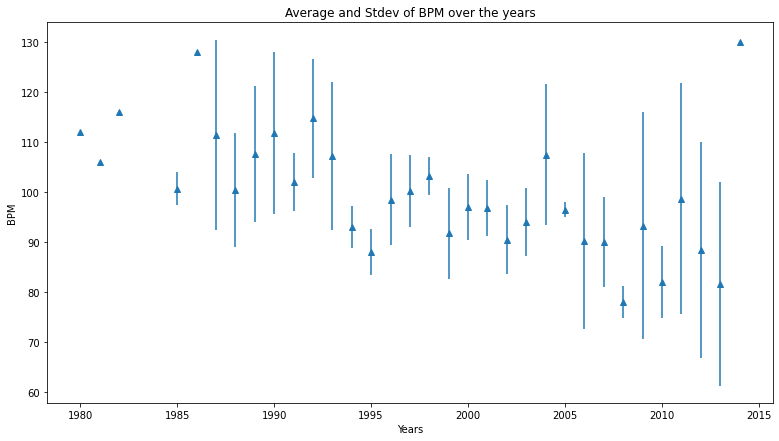

In [43]:
plt.figure(figsize = (13, 7))
plt.errorbar(unique_yrs, mean_by_yr, std_by_yr, linestyle='None', marker='^')
plt.title('Average and Stdev of BPM over the years')
plt.xlabel('Years')
plt.ylabel('BPM')

### Linear regression on mean values

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
x = unique_yrs.reshape((-1, 1))
y = mean_by_yr
model = LinearRegression()
model.fit(x, y)

LinearRegression()

In [50]:
r_sq = model.score(x, y)
slope = model.coef_
print(f"coefficient of determination: {r_sq}, slope: {slope}")

coefficient of determination: 0.26729213728342804, slope: [-0.63013681]


Text(0.5, 0, 'Years')

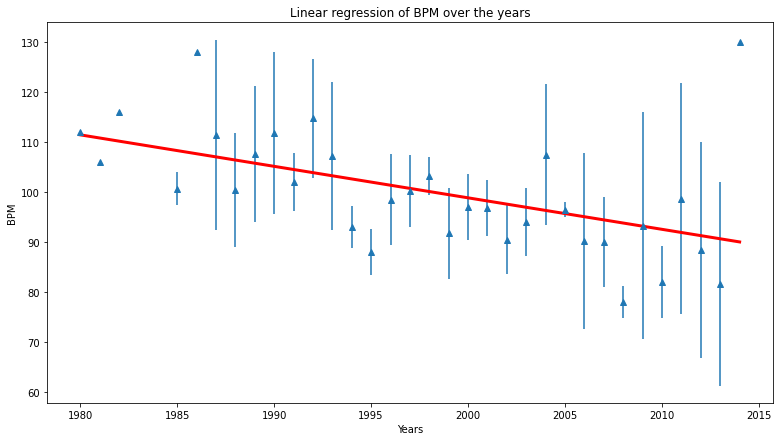

In [64]:
y_pred = model.predict(x)

plt.figure(figsize = (13, 7))
plt.errorbar(unique_yrs, mean_by_yr, std_by_yr, linestyle='None', marker='^')
plt.plot(x, y_pred, color="red", linewidth=3)
plt.title('Linear regression of BPM over the years')
# plt.title('Mean and Stdev of BPM over the years')
plt.ylabel('BPM')
plt.xlabel('Years')
# plt.savefig('images/mean_stdev_BPM.png')